# TME UE IAR: From Traditional EA to Quality-Diversity algorithms

Cette séance de TME consiste à mettre en oeuvre des méthodes d'apprentissage de type "direct policy search" s'appuyant sur des algorithmes évolutionnistes. 

Ces algorithmes s'appuient sur des opérateurs de recherche stochastiques. Si vous lancez plusieurs fois une même expérience avec une graine aléatoire différente vous obtiendrez des résultats différents. Dans la mesure du possible et de la puissance de calcul que vous avez à disposition et s'il n'a pas été demandé explicitement de ne faire qu'une seule expérience, il est donc souhaitable de répéter les expériences plusieurs fois avant de conclure.

Les cellules à compléter sont marquées <à compléter>.

Vous prendrez soin de ne soumettre que les fichiers nécessaires (merci d'éviter les fichiers de log inutiles et de taille conséquente...).

## 1. Introduction



### 1.1 Dépendances

L'environnement `FastsimSimpleNavigation-v0` de gym_fastsim permet de lancer des expériences de navigation avec un robot à roues naviguant dans un labyrinthe. Il se présente sous la forme d'une bibliothèque en C++ (libfastsim), d'une interface en python (pyfastsim) et d'une interface gym (fastsim_gym). Ces trois bibliothèques vous sont fournies avec un README qui explique comment les installer. En bref:
* libfastsim: `./waf configure` et `./waf build` (dépendance optionnelle SDL 1.2)
* pyfastsim: `pip3 install .` (dépendances: compilateur compatible c++14, module pybind11 avec module de développement associé)
* fastsim_gym: `pip3 install .` (dépendance: gym)




### 1.2 Code fourni

Le code vous permettant de reproduire les expériences de Lehman et Stanley sur la recherche de nouveauté vous est fourni (ceux qui ont suivi l'UE robotique et apprentissage de M1 l'ont fait en TME l'an dernier).

Contenu des fichiers fournis:
* fixed_structure_nn_numpy.py: réseau de neurones à structures fixe qui servira de politique paramétrée
* maze_plot.py: fonctions pour tracer l'espace comportemental associé aux expériences de Lehman et Stanley (navigation dans un labyrinthe)
* plot.py: fonctions pour tracer des fronts de pareto

Code à modifier/compléter:
* ea_dps.py: c'est le fichier principal pour lancer une expérience 
* novelty_search.py: gestion d'un objectif de nouveauté
* grid_management.py: gestion d'une grille pour suivre l'avancement de l'exploration et implémenter MAP-Elites

Ce code inclut des facilités pour enregistrer des logs, sauvegarder des trajectoires et les tracer ensuite.



### 1.3 Import

In [128]:
# Il n'y a rien à faire d'autre que d'exécuter cette cellule, 
# elle contient des imports qui vous seront utiles

# Note: l'import d'un fichier ne se fait qu'une seule fois. Si vous modifiez ce fichier, 
# il vous faut redémarrer votre kernel si vous voulez prendre en compte les modifications.
# vous pouvez éviter cela de la façon suivante: 
import importlib # une seule fois
import plot # le module doit avoir été importé une première fois
importlib.reload(plot) # cette ligne permet de charger la dernière version

import matplotlib.pyplot as plt
import numpy as np
import glob
import re
from maze_plot import plot_traj_file, plot_points, plot_points_lists


# pour que les figures apparaissent directement dans le notebook
%matplotlib inline 

## 2 Comparaison des expériences de Fit, NS et Fit+NS

Cette première partie vise à vous faire prendre en main le code de l'expérience de navigation dans un labyrinthe et ses variantes NS, FIT et FIT+NS. 

Vous regarderez attentivement le fichier ea_dps.py et vous le compléterez pour afficher un message chaque fois qu'une politique s'approche de la sortie plus que ce qui a été fait auparavant. A cette occasion, vous sauvegarderez la trajectoire de cet individu (vous devrez pour cela le réévaluer en mettant le paramètre dump à True) pour pouvoir la tracer ensuite dans les questions suivantes de ce notebook.

### 2.1 Variante Fit

Lancez quelques expériences avec la variante FIT et indiquez le nombre moyen de générations pour atteindre la sortie (avec un nombre maximum de générations de 200). Vous pouvez l'obtenir en regardant les fichiers info.log générés et en cherchant la première génération où apparait un 'exit_reached': 1.0.



In [31]:
#le code suivant permet d'interpréter une ligne contenant un dictionnaire, vous pouvez vous en inspirer pour lire les fichiers info.log 
# et extraire les valeurs de exit_reached.
import ast


# pour relire un dictionnaire depuis info.log, vous pourrez utiliser le code suivant:
y = ast.literal_eval("{'foo' : 'bar', 'hello' : 'world'}")
print(str(y))

{'foo': 'bar', 'hello': 'world'}


In [115]:
folder = "completed_runs"

def exit_reached_at(run):
    """ str -> bool
        Retourne la première génération où la sortie est atteinte
        Retourne -1 si la sortie n'est jamais atteinte
    """
    exit = -1 # première generation où exit_reached=1.0 apparaît
    gen = -1
    with open(folder+"/"+run+"/info.log") as f:
        line = f.readline()
        while(line):
            if line[0:13] == "## Generation":
                gen += 1 # next generation
            elif line[0]!='#':
                obj = ast.literal_eval(line)
                if obj['exit_reached'] == 1.0:
                    exit = gen
                    print("1")
                    break
            line = f.readline()
    return exit

def exit_reached_moy(runs):
    """ Retourne la génération moyenne à laquelle la sortie est atteinte"""
    moy = 0
    n = 0
    for run in runs:
        gen = exit_reached_at(run)
        if gen != -1:
            moy += gen
            n += 1
    if n == 0:
        print("Sortie jamais atteinte !")
    else :
        print("Sortie atteinte "+str(n)+" fois, au bout d'en moyenne "+str(int(moy/n))+" générations")

In [103]:
runs_FIT = ["res_fastsim_FIT_2020_12_22_22:36:01", "res_fastsim_FIT_2020_12_22_22:36:01",
       "res_fastsim_FIT_2020_12_22_22:42:17", "res_fastsim_FIT_2020_12_22_22:46:18",
       "res_fastsim_FIT_2020_12_22_22:51:53"]
# indiquer ici la valeur moyenne trouvée 
# valeur moyenne sur 5 runs avec 50 générations
exit_reached_moy(runs_FIT)

Sortie jamais atteinte !


Tracez les trajectoires générées par les individus qui ont fait progresser la fitness pendant une expérience. Vous pourrez utiliser la fonction plot_traj_file qui est dans le fichier maze_plot.py.

In [84]:
def plot_trajs(run):
    files = glob.glob(folder+"/"+run+"/traj_robot_pos*")
    files.sort()
    for file in files:
        gen = re.findall(r'\d+', file)[-1]
        plot_traj_file(file, title="generation "+gen)

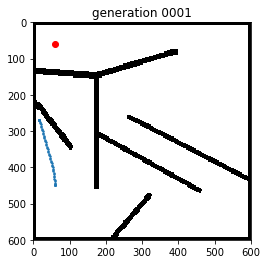

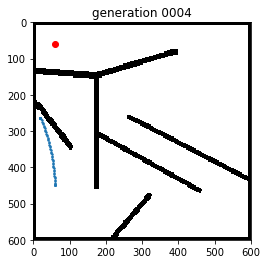

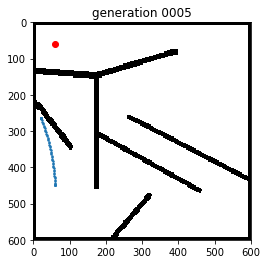

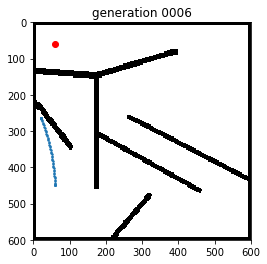

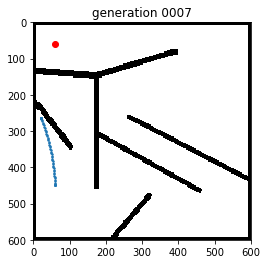

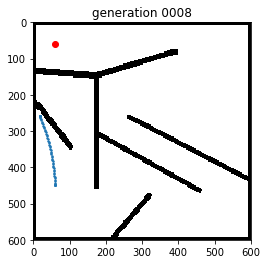

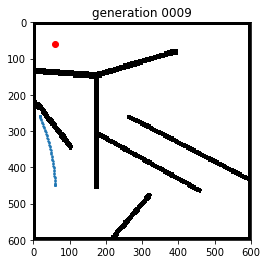

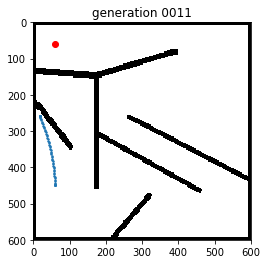

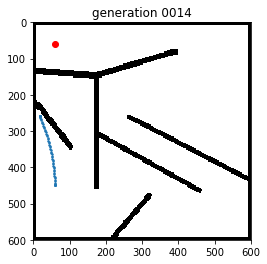

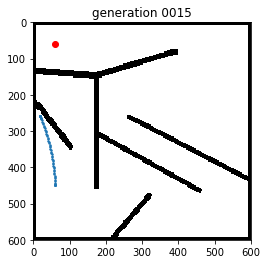

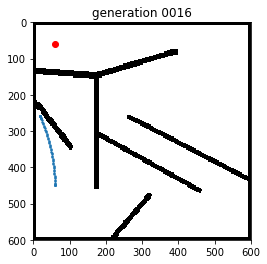

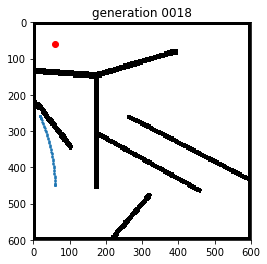

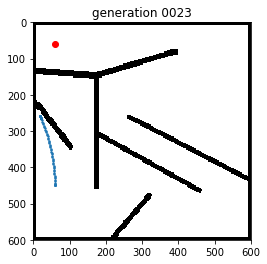

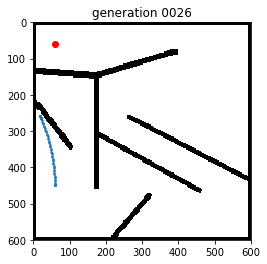

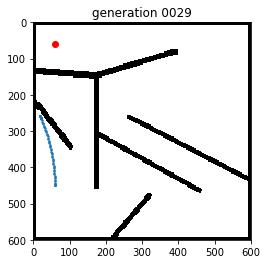

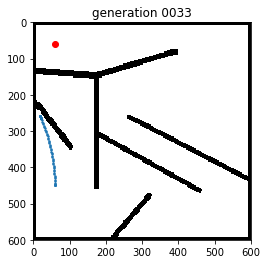

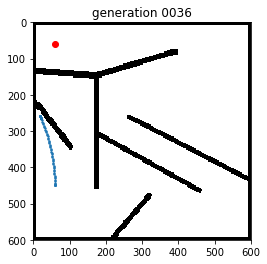

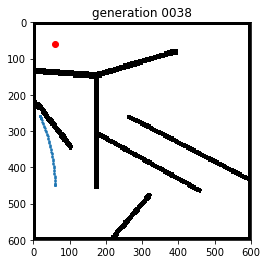

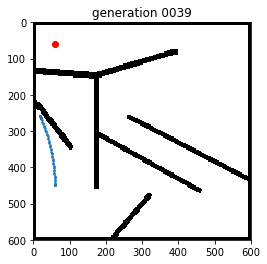

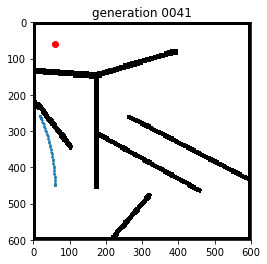

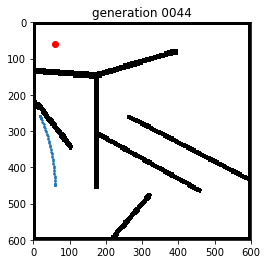

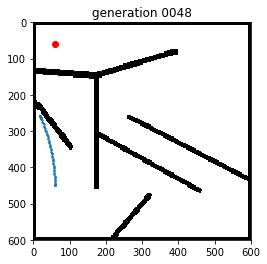

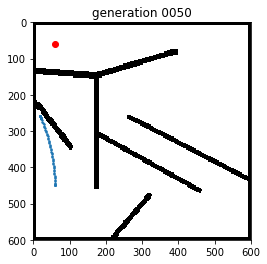

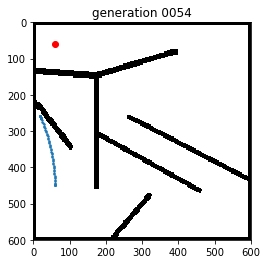

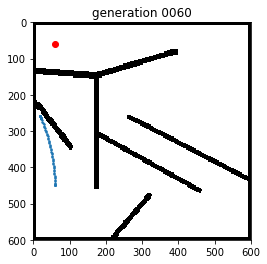

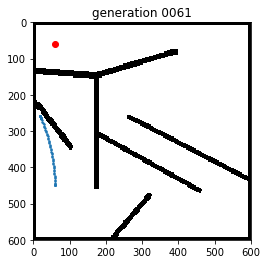

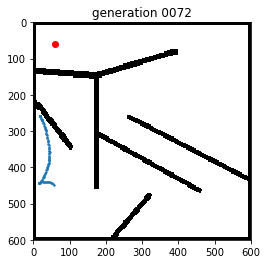

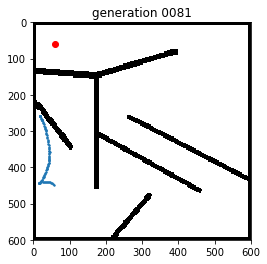

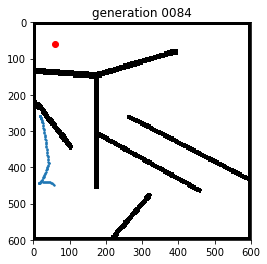

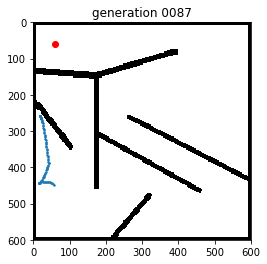

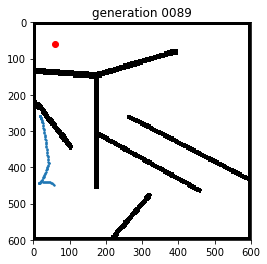

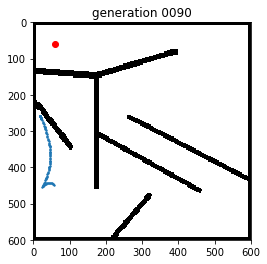

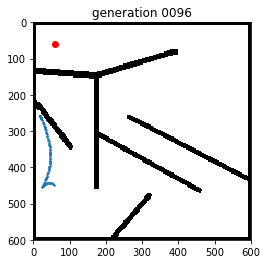

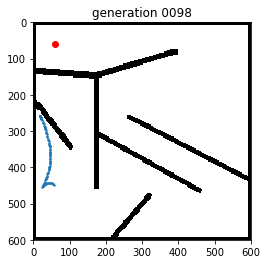

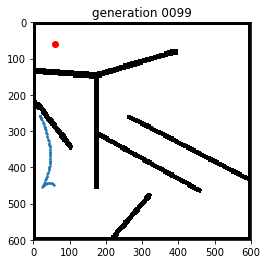

In [98]:
# trajectoires des individus améliorant la fitness
run = "res_fastsim_FIT_2020_12_22_22:36:01"
plot_trajs(run)

Les individus se retrouvent rapidement bloqués entre deux murs au mileur à gauche et peinent à en sortir.

### 2.2 Variante NS

Mêmes questions avec la variante NS: lancez quelques expériences avec cette variante et indiquez le nombre moyen de générations pour atteindre la sortie (avec un nombre maximum de générations de 200). 

Tracez les trajectoires générées par les individus qui ont fait progresser la fitness pendant une expérience.

In [108]:
runs_NS = ["res_fastsim_NS_2020_12_22_21:07:50", "res_fastsim_NS_2020_12_22_21:27:57",
          "res_fastsim_NS_2020_12_22_21:45:43", "res_fastsim_NS_2020_12_22_22:03:15",
          "res_fastsim_NS_2020_12_22_22:15:12"]

# indiquer ici la valeur moyenne trouvée et compléter avec le code permettant de tracer les trajectoires.
exit_reached_moy(runs_NS)

Sortie atteinte 4 fois, au bout d'en moyenne 68 générations


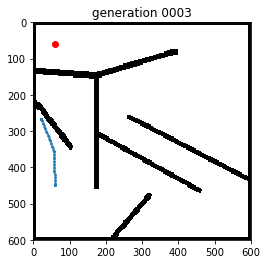

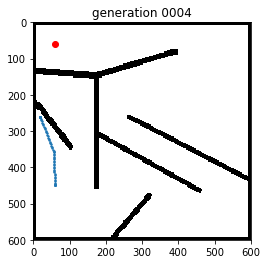

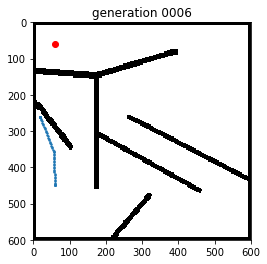

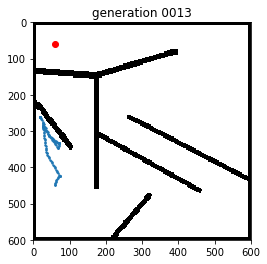

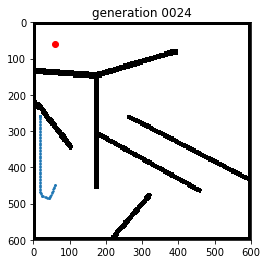

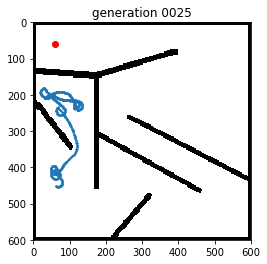

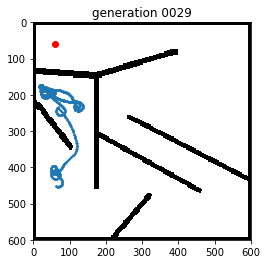

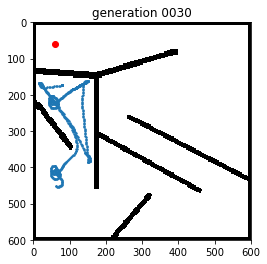

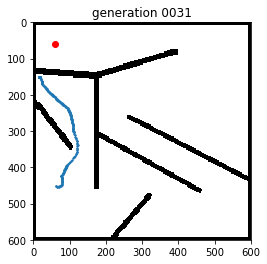

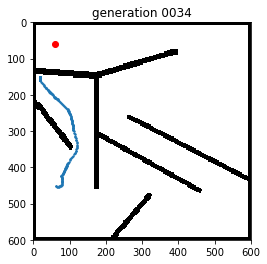

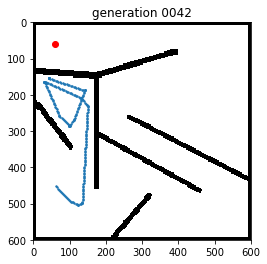

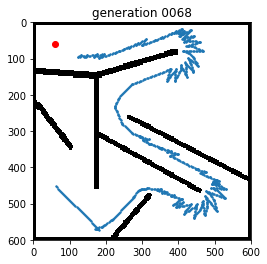

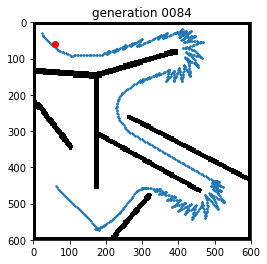

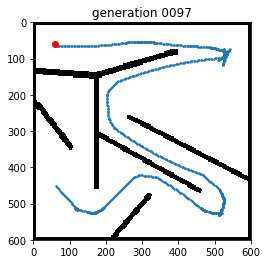

In [85]:
run ="res_fastsim_NS_2020_12_22_21:07:50"
plot_trajs(run)

Avec la variante NS on les individus explorent plus, on atteint l'objectif au bout de 84 générations, et au bout de 97 générations on obtient de bonnes trajectoires.

### 2.3 Variante FIT+NS

Mêmes questions avec la variante qui utilise 2 objectifs: Fitness et Novelty (variante FIT+NS). Lancez quelques expériences avec cette variante et indiquez le nombre moyen de générations pour atteindre la sortie (avec un nombre maximum de générations de 200). 

Tracez les trajectoires générées par les individus qui ont fait progresser la fitness pendant une expérience.

In [116]:
runs_FIT_NS = ["res_fastsim_FIT_NS_2020_12_22_23:07:48", "res_fastsim_FIT_NS_2020_12_22_23:21:14",
             "res_fastsim_FIT_NS_2020_12_22_23:26:29", "res_fastsim_FIT_NS_2020_12_22_23:43:14",
             "res_fastsim_FIT_NS_2020_12_23_00:00:32"]

# indiquer ici la valeur moyenne trouvée et compléter avec le code permettant de tracer les trajectoires.
exit_reached_moy(runs_FIT_NS)

Sortie jamais atteinte !


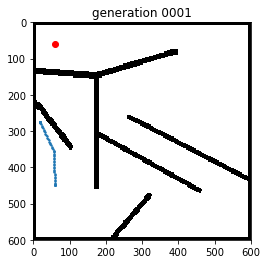

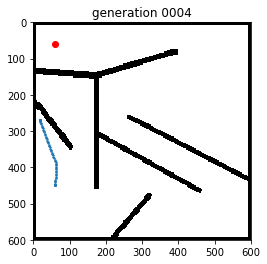

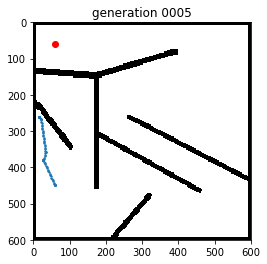

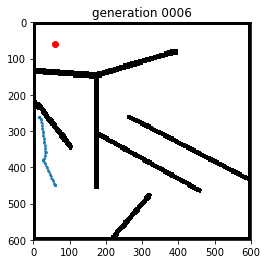

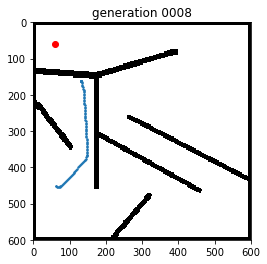

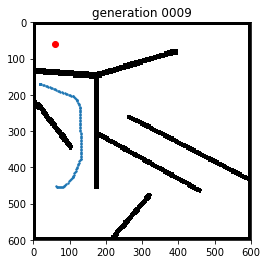

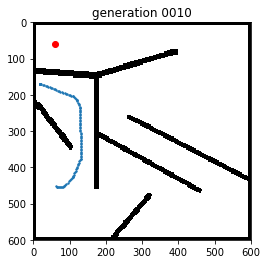

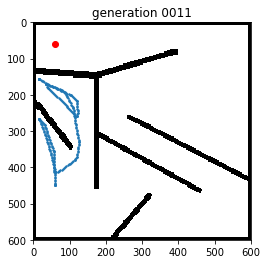

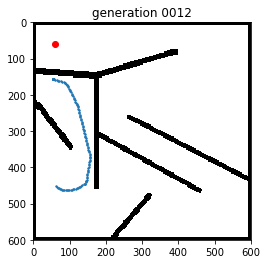

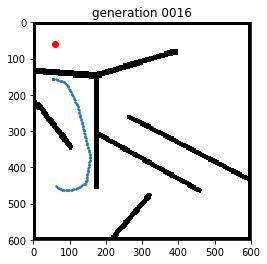

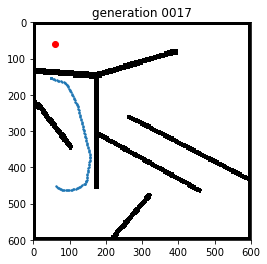

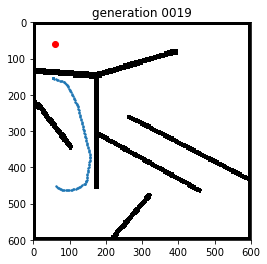

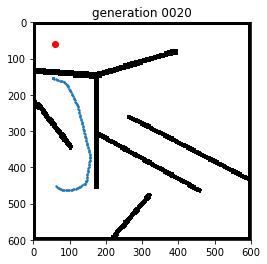

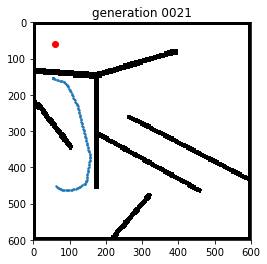

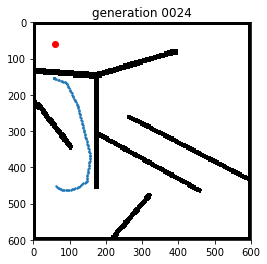

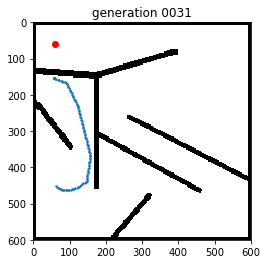

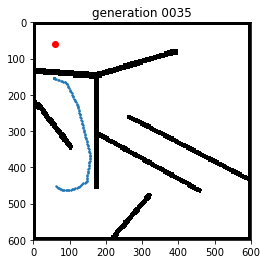

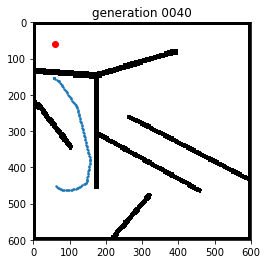

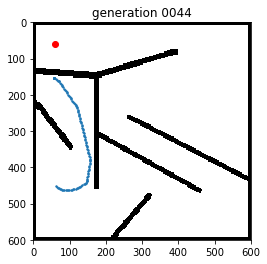

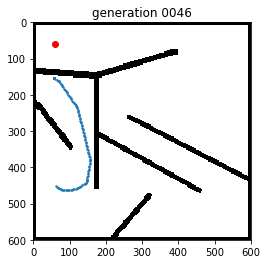

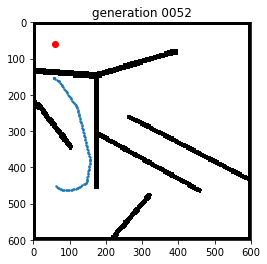

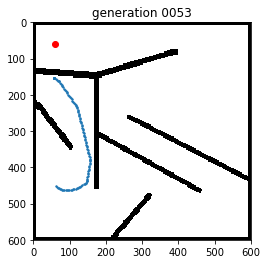

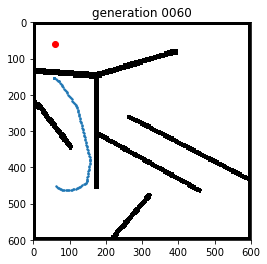

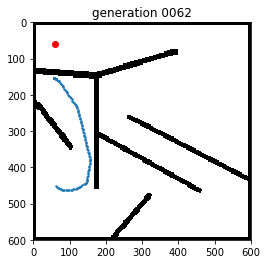

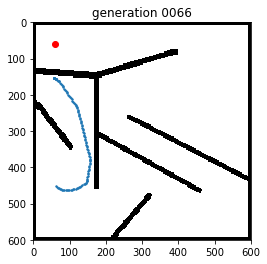

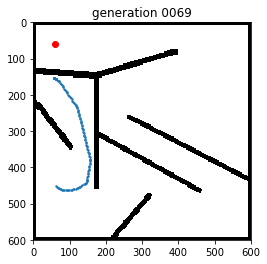

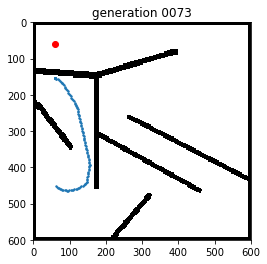

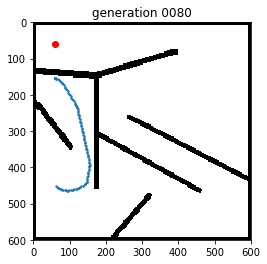

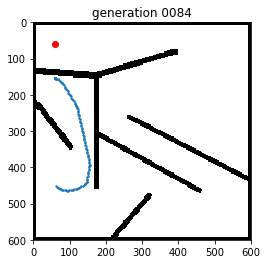

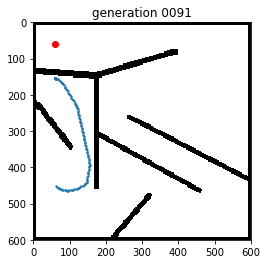

In [120]:
run = "res_fastsim_FIT_NS_2020_12_22_23:21:14"
plot_trajs(run)

L'algorithme FIT-NS cherche à la fois à fitness et la nouveauté, ce qui lui permet d'éviter de se retrouver coincé dans des zones comme lorsqu'on cherche à améliorer la fitness seule. On voit que les individus progressent dans l'espace au fil des générations, du fait de la recherche de nouveauté, mais qu'ils tendent aussi à se diriger dans les coins pour satisfaire la fitness car ceux-ci les rapprochent de la sortie.

## 3 Diversité des comportements générés




La position finale de chaque point généré est enregistrée dans le fichier info.log (champ robot_pos). Tracez ces différents points sur une même figure pour une experience de NS, de FIT et de FIT+NS. Vous tracerez sur une figure l'ensemble des points générés par une expérience de chaque variante. Qu'en déduisez-vous sur la capacité d'exploration de chacun de ces algorithmes ? Vous pourrez le comparer à un échantillonnage aléatoire (il suffit de mettre 0 générations et pour mu le nombre d'échantillons souhaités).

In [133]:
def get_final_pos(run):
    """ Retourne les positions finale des points générés """
    positions = []
    with open(folder+"/"+run+"/info.log") as f:
        line = f.readline()
        while(line):
            if line[0]!='#':
                obj = ast.literal_eval(line)
                positions.append((obj['robot_pos'][0], obj['robot_pos'][1]))
            line = f.readline()
    return positions

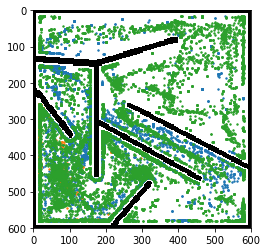

In [143]:
run_FIT = "res_fastsim_FIT_2020_12_22_22:36:01"
run_NS = "res_fastsim_NS_2020_12_22_21:27:57"
run_FIT_NS = "res_fastsim_FIT_NS_2020_12_22_23:07:48"
run_random = "res_fastsim_RANDOM_2020_12_23_01:38:08"
    
# pour tracer un ensemble de points, vous pourrez utiliser maze_plot.plot_points(pts)
pos_FIT = get_final_pos(run_FIT)
pos_NS = get_final_pos(run_NS)
pos_FIT_NS = get_final_pos(run_FIT_NS)
pos_random = get_final_pos(run_random)

plot_points_lists([pos_FIT_NS, pos_FIT, pos_NS])

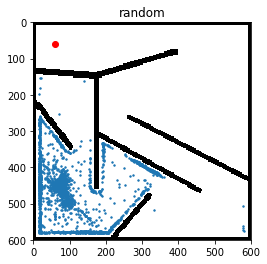

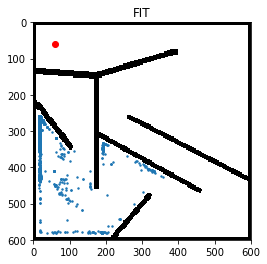

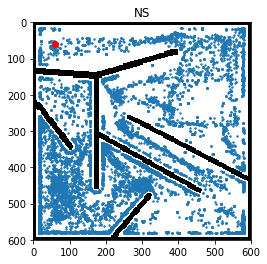

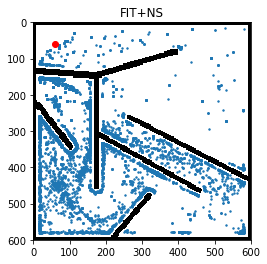

In [145]:
plot_points(pos_random, title="random")
plot_points(pos_FIT, title="FIT")
plot_points(pos_NS, title="NS")
plot_points(pos_FIT_NS, title="FIT+NS")

Pour résumer :
- FIT : pas d'exploration, on cherche jsute à améliorer le score. On se retrouve vite coincé dans un maximum local,
- NS : Exploitation seule (on ne cherche pas à maximiser l'objectif), donc une grosse partie de la map est visitée. Meilleure exploration que l'aléatoire,
- FIT-NS : On a un compromis exploration/exploitation (amas de points aux bords des murs).

Tracez sur des figures séparées les points générés pour plusieurs générations successives de NS, FIT et FIT+NS (par exemple 90, 91, 92). Que constatez vous ? 

In [147]:
def get_final_pos_gen(run, generation):
    """ Retourne les positions finale des points générés """
    positions = []
    gen = -1
    with open(folder+"/"+run+"/info.log") as f:
        line = f.readline()
        while(line):
            if line[0:13] == "## Generation":
                gen += 1
            if line[0]!='#' and gen==generation:
                obj = ast.literal_eval(line)
                positions.append((obj['robot_pos'][0], obj['robot_pos'][1]))
            line = f.readline()
    return positions

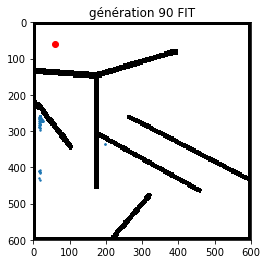

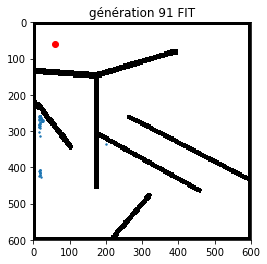

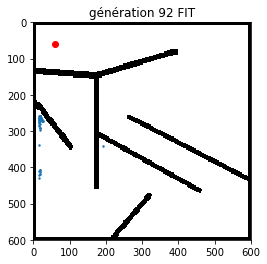

In [151]:
# FIT
get_final_pos
plot_points(get_final_pos_gen(run_FIT,90), title="génération 90 FIT")
plot_points(get_final_pos_gen(run_FIT,91), title="génération 91 FIT")
plot_points(get_final_pos_gen(run_FIT,92), title="génération 92 FIT")

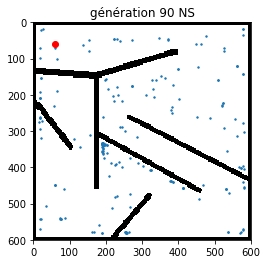

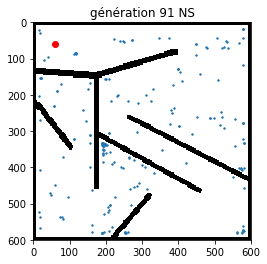

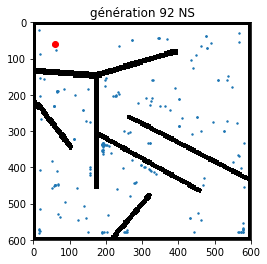

In [150]:
# NS
plot_points(get_final_pos_gen(run_NS,90), title="génération 90 NS")
plot_points(get_final_pos_gen(run_NS,91), title="génération 91 NS")
plot_points(get_final_pos_gen(run_NS,92), title="génération 92 NS")

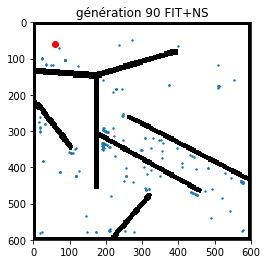

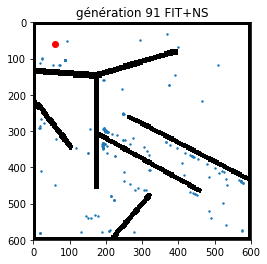

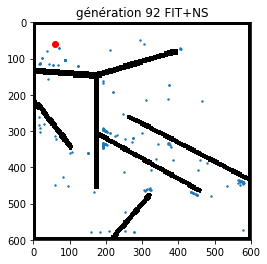

In [152]:
# FIT+NS
plot_points(get_final_pos_gen(run_FIT_NS,90), title="génération 90 FIT+NS")
plot_points(get_final_pos_gen(run_FIT_NS,91), title="génération 91 FIT+NS")
plot_points(get_final_pos_gen(run_FIT_NS,92), title="génération 92 FIT+NS")

On constate qu'avec FIT, les points finaux sont regroupés dans une même zone et diffèrent peu d'une génération à l'autre. On a plus de points regroupés dans le coin du mur car les individus tentent de se rapprocher de la solution.

Avec NS, les points sfinaux ont répartis dans toute la zone du labyrinthe. On a pas ou peu d'amas de points au même endroit, est cela est pertinent car on cherche à avoir de la nouveauté et donc de la diversité.

Avec FIT+NS, les points finaux sont, tout comme avec NS, répartis sur tout la map. En revanche, on a d'une génération à l'autre (par exe. de la génération 91 à la génération 92) plus de "paquets" de points dans les zones de "maximums locaux", c'est à dire donnant localement une bonne fitness.

## 4 Ajout d'une qualité locale

L'ensemble des solutions générées peut être utilisé pour atteindre n'importe lequel des comportements atteignables, mais l'inconvénient de cette approche est que la notion de qualité est totalement absente du processus, or parmi les solutions générant un comportement donné, toutes ne se valent pas. Certaines sont plus intéressantes que d'autres parce qu'elles consomment moins d'énergie, qu'elles ne créent pas de collision, etc.

Une solution pour prendre en compte un tel critère de qualité consiste à utiliser, à côté de l'objectif de nouveauté, un objectif de performance. Définir cet objectif comme une pression globale est contreproductif, car pour éviter des collisions ou minimiser la consommation d'énergie, il suffit de ne pas bouger... Pour rendre cette pression plus intéressante, il faut en faire un objectif non pas global, mais local.

Pour cela, on peut suivre l'approche proposée par Lehman et Stanley [1]: on compare la fitness de l'individu considéré avec celle de ses plus proches voisins (qui sont déjà déterminés pour le calcul de nouveauté). L'objectif de compétition locale vaut le nombre de voisins dont la fitness est inférieure.

Complétez le code de novelty_search.py pour que la fonction de calcul de nouveauté renvoie la nouveauté et l'objectif de compétition locale. Pour cela, vous devrez garder dans l'archive la liste des fitness des points ajoutés.

Utilisez cette nouvelle version pour générer des politiques qui permettent d'atteindre les différentes positions du labyrinthe en minimisant le nombre de collision du robot avec les murs, par exemple.

Vous tracerez les trajectoires des meilleurs individus générés.

* [1] Lehman, J., & Stanley, K. O. (2011). Evolving a diversity of virtual creatures through novelty search and local competition. In Proceedings of GECCO

In [60]:
# <à compléter>


## 5 "Illuminer" l'espace exploré

### 5.1 Quantifier l'espace comportemental exploré

Définissez une grille dans l'espace comportemental qui va vous permettre de mesurer l'espace exploré. Découpez l'espace en cases (vous ignorerez les murs pour simplifier) et écrivez une fonction permettant de placer un individu dans case correspondant à son descripteur comportemental une fois qu'il a été évalué. Il n'y aura qu'un seul individu par case. Lorsque vous tentez d'ajouter un individu dans une case, si elle est déjà remplie, le nouvel individu remplacera l'ancien si sa fitness est plus élevée. 

Cette grille est (pour l'instant) indépendante de l'algorithme d'apprentissage. Elle vise simplement à mesurer la capacité de ce dernier à explorer cet espace et à retrouver facilement, si besoin, une politique efficace permettant d'atteindre un comportement donné.

Vous mesurerez la couverture de votre exploration (pourcentage de cellules explorées). Utilisez une grille de 100x100 cases sur l'expérience de navigation dans le labyrinthe et déterminez la couverture pour les trois variantes: FIT, NS, FIT+NS et NSLC (vous vous contenterez d'une seule expérience).

A la fin de votre expérience, vous afficherez le nombre de cellules que vous pouvez atteindre sans collision. Vous tracerez les trajectoires associées à quelques unes d'entre elles.

In [4]:
# <à compléter>

# indiquez ici les résultats trouvés

### 5.2 OPTION: MAP-Elites

#### 5.2.1 Implémentation de MAP-Elites

La grille définie à la question précédente permet de définir un algorithme très simple: MAP-Elites [1]. Dans cet algorithme, la sélection s'appuie sur la grille. La génération d'un nouvel individu consiste à tirer aléatoirement un (si mutation uniquement) ou deux individus (si croisement) dans la grille puis à appliquer l'opérateur génétique de mutation ou de croisement. Après évaluation, on tente d'ajouter cet individu dans la grille et on 

Utilisez cet algorithme sur la tâche de navigation et indiquer le nombre de cellules atteignables sans collision. Vous pourrez tracer des trajectoires associées à quelques unes d'entre elles.


MAP-Elites est un algorithme très simple. Le prix à payer est qu'il est bien plus lent que Novelty search pour couvrir l'espace atteignable. Ses performances peuvent être améliorées si le génotype est de plus petite taille. 

* [1] Mouret, J. B., & Clune, J. (2015). Illuminating search spaces by mapping elites. arXiv preprint arXiv:1504.04909

In [4]:
# <à compléter>

# indiquez ici les résultats trouvés

#### 5.2.2 Variantes de MAP-Elites

MAP-Elites peut aussi être amélioré avec des stratégies de choix des parents qui ne sont plus uniformes sur toute la grille, mais biaisées pour favoriser les cellules isolées ou les individus dont les descendants ont réussi à remplir des cellules (score de "curiosité" [1]). 

* [1] Cully, A., & Demiris, Y. (2017). Quality and diversity optimization: A unifying modular framework. IEEE Transactions on Evolutionary Computation, 22(2), 245-259.

In [4]:
# <à compléter>

# indiquez ici les résultats trouvés